# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [1]:
# I will be running this notebook in Colab so I need to clone the repo inside the notebook
!git clone https://github.com/udacity/nd320-c3-3d-imaging-starter.git
%cd nd320-c3-3d-imaging-starter

Cloning into 'nd320-c3-3d-imaging-starter'...
remote: Enumerating objects: 1291, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 1291 (delta 25), reused 18 (delta 18), pack-reused 1235 (from 1)
Receiving objects: 100% (1291/1291), 178.23 MiB | 17.57 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Updating files: 100% (949/949), done.
/content/nd320-c3-3d-imaging-starter


In [3]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# TASK: Import the following libraries that we will use: nibabel, matplotlib, numpy
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
# For clearer slice visuals later
plt.rcParams["figure.figsize"] = (8, 8)

It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [7]:
!ls /content/nd320-c3-3d-imaging-starter/

CODEOWNERS  data  readme.img  README.md  section1  section2  section3


In [8]:
!ls /content/nd320-c3-3d-imaging-starter/data/TrainingSet/

images	labels


In [9]:
# TASK: Your data sits in directory /data/TrainingSet.
# Load an image and a segmentation mask into variables called image and label

# Set file paths
image_path = 'data/TrainingSet/images/hippocampus_001.nii.gz'
label_path = 'data/TrainingSet/labels/hippocampus_001.nii.gz'

# Load using nibabel
nii_img = nib.load(image_path)
nii_lab = nib.load(label_path)

# Convert to NumPy arrays
image = nii_img.get_fdata()
label = nii_lab.get_fdata()

# Print shapes
print("\033[1m" + "Answer" + "\033[0m" + ": Dimensions of the input arrays are:", image.shape)

Answer: Dimensions of the input arrays are: (35, 51, 35)


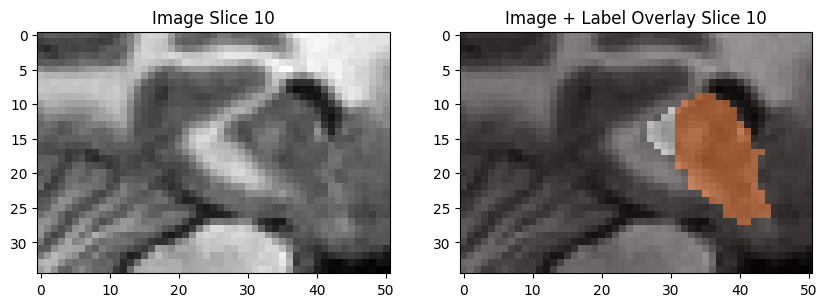

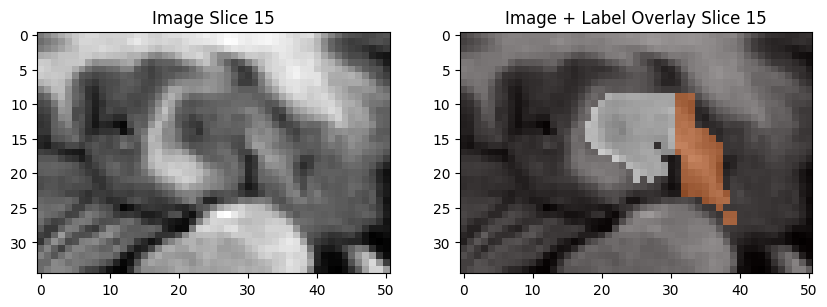

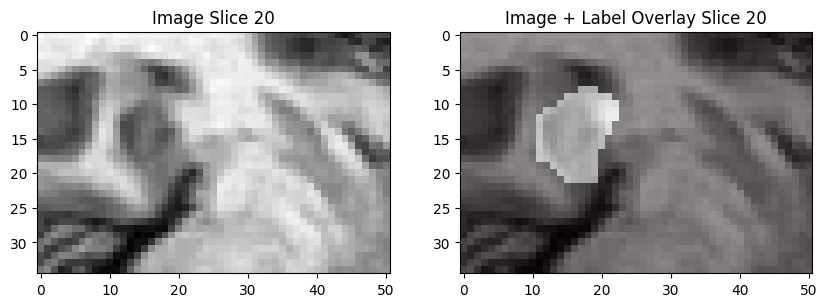

In [10]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities.
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

# TASK: using matplotlib, visualize a few slices from the dataset, along with their labels.
# You can adjust plot sizes like so if you find them too small:
# plt.rcParams["figure.figsize"] = (10,10)

import matplotlib.pyplot as plt

# Optional: make plots larger
plt.rcParams["figure.figsize"] = (10, 5)

# Choose some slice indices
slice_idx = [10, 15, 20]

for i in slice_idx:
    fig, ax = plt.subplots(1, 2)

    ax[0].imshow(image[:, :, i], cmap="gray")
    ax[0].set_title(f"Image Slice {i}")

    ax[1].imshow(image[:, :, i], cmap="gray")
    ax[1].imshow(label[:, :, i], cmap="hot", alpha=0.4)  # overlay segmentation mask
    ax[1].set_title(f"Image + Label Overlay Slice {i}")

    plt.show()

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

![3D slicer](img/Slicer.png)

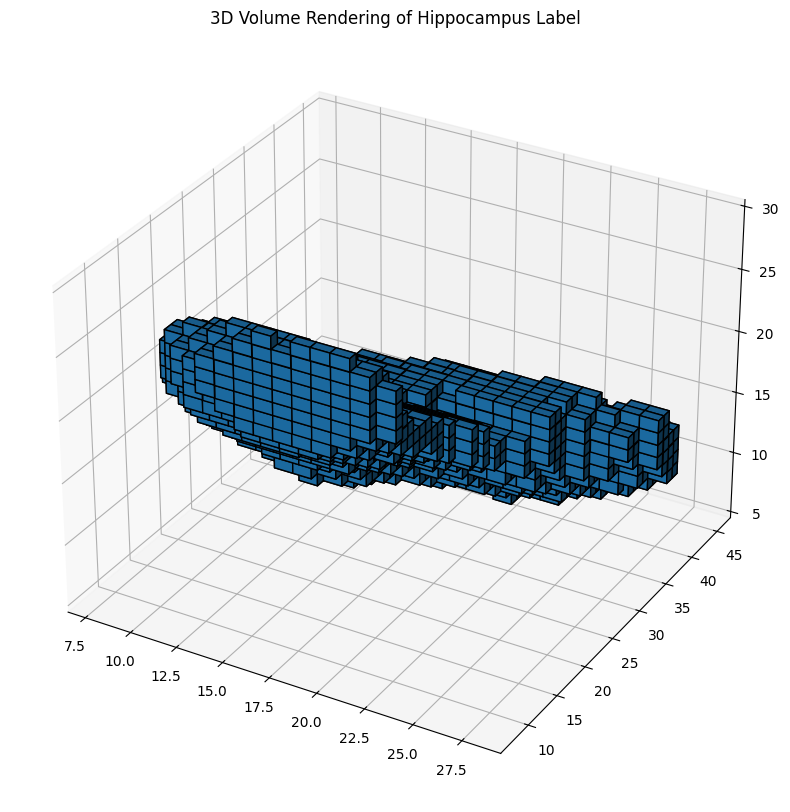

In [11]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes

from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Only show the labeled voxels
label_mask = label > 0

# Plot
ax.voxels(label_mask, edgecolor='k')
plt.title("3D Volume Rendering of Hippocampus Label")
plt.show()


## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [13]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?

# Inspect NIfTI metadata
header = nii_lab.header
print("Header class of the label file:", type(nii_lab.header))

Header class of the label file: <class 'nibabel.nifti1.Nifti1Header'>


Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [14]:
# TASK: How many bits per pixel are used?
print("Bits per voxel:", header['bitpix'])

Bits per voxel: 8


In [17]:
# TASK: What are the units of measurement?
units_code = header['xyzt_units']
print("Raw xyzt_units code:", units_code)

# Decode manually based on the NIfTI specification
# 2 → millimeters (mm) and 8 → seconds (s) so 10 = 2 + 8
if units_code == 10:
    spatial_unit = "millimeters (mm)"
    temporal_unit = "seconds (s)"
else:
    spatial_unit = "unknown"
    temporal_unit = "unknown"

print(f"Answer: Spatial units = {spatial_unit}, Temporal units = {temporal_unit}")

Raw xyzt_units code: 10
Answer: Spatial units = millimeters (mm), Temporal units = seconds (s)


In [18]:
# TASK: Do we have a regular grid? What are grid spacings?
# Grid dimensions (shape of the volume)
print("Grid dimensions (dim):", header["dim"][1:4])

# Grid spacings (voxel size in mm)
print("Voxel spacings (pixdim):", header["pixdim"][1:4])

# Interpret result
print("Answer: This is a regular grid, with equal spacing of 1mm in all directions.")

Grid dimensions (dim): [35 51 35]
Voxel spacings (pixdim): [1. 1. 1.]
Answer: This is a regular grid, with equal spacing of 1mm in all directions.


In [19]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?
dims = header["dim"][1:4]
print("Sagittal (x), coronal (y), and axial (z) dimensions are:", dims)

print(
    "Answer: Sagittal = x = dim[1], Coronal = y = dim[2], Axial = z = dim[3]. "
    "This is standard in NIfTI format using left-handed coordinate system. "
    "In this case: x=35, y=51, z=35."
)


Sagittal (x), coronal (y), and axial (z) dimensions are: [35 51 35]
Answer: Sagittal = x = dim[1], Coronal = y = dim[2], Axial = z = dim[3]. This is standard in NIfTI format using left-handed coordinate system. In this case: x=35, y=51, z=35.


In [20]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded.
# You should get a number between ~2200 and ~4500

# Count all voxels that are labeled (non-zero)
num_voxels = np.sum(label > 0)
print("Number of labeled voxels:", num_voxels)

# Each voxel is 1mm³, so:
voxel_volume = np.prod(header["pixdim"][1:4])  # should be 1 * 1 * 1 = 1 mm³

# Total physical volume
hippo_volume = num_voxels * voxel_volume
print("\033[1m" + f"Answer: Volume of hippocampus in hippocampus_001.nii.gz is {hippo_volume:.2f} mm³" + "\033[0m")


Number of labeled voxels: 2948
Answer: Volume of hippocampus in hippocampus_001.nii.gz is 2948.00 mm³


## Plotting some charts

In [21]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how
# our dataset measures against a slice of a normal population represented by the chart below.
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Path to label files
label_path = "data/TrainingSet/labels"

In [22]:
# List all label files
label_files = os.listdir(label_path)
print("Total label files found:", len(label_files))

Total label files found: 262


In [23]:
# Compute volume of each label
all_volumes = []
for f in label_files:
    label_nii = nib.load(os.path.join(label_path, f))
    label_data = label_nii.get_fdata()
    volume = np.sum(label_data > 0)  # voxel count
    all_volumes.append(volume)

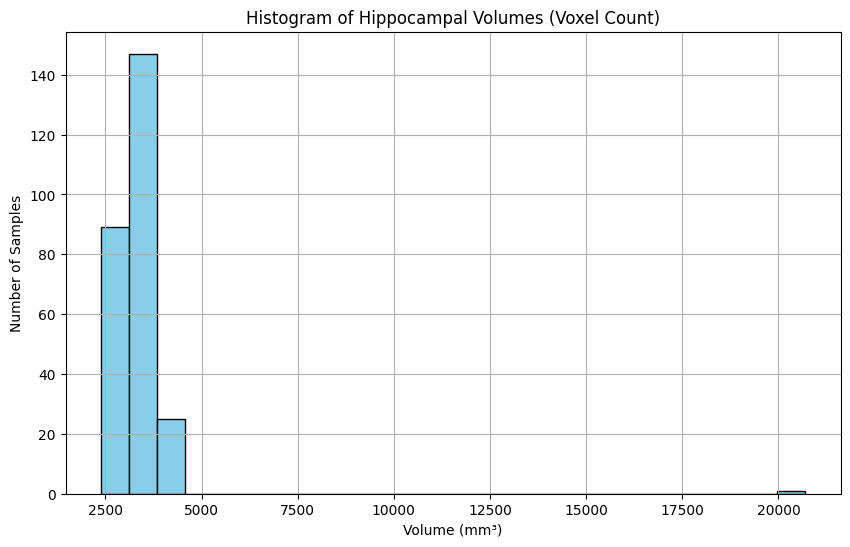

Mean hippocampal volume: 3362.26 mm³


In [24]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_volumes, bins=25, color="skyblue", edgecolor="black")
plt.title("Histogram of Hippocampal Volumes (Voxel Count)")
plt.xlabel("Volume (mm³)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

# Mean volume
print(f"Mean hippocampal volume: {np.mean(all_volumes):.2f} mm³")

<img src="https://raw.githubusercontent.com/udacity/nd320-c3-3d-imaging-starter/895fee683624aafe2033521f4d9b6d99accd66d5/section1/img/nomogram_fem_right.svg" width="400" align="left">



Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

## 📊 **What the Histogram Tells Us**

The histogram above represents the distribution of hippocampal volumes (in mm³) across all label files in the dataset. Most of the volumes fall within a tight range of 2500 to 4500 mm³, which aligns with expected anatomical values in a normal adult population.

However, we observe a clear **outlier around 20,000 mm³** — an order of magnitude larger than the mean (~3362 mm³). This suggests the presence of corrupted or incorrectly cropped labels. These anomalies are not consistent with the expected shape and size of the hippocampus and may indicate volumes that were not pre-processed correctly.

**To ensure a clean and consistent dataset for training, these outliers will be excluded from the curated dataset used in the next phase of the project.**



In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one.

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [25]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section

#Define the files we exclude
# Files to exclude (based on missing label, and extremely large outlier volumes)
exclude = ["hippocampus_010.nii.gz", "hippocampus_281.nii.gz", "hippocampus_118.nii.gz"]


In [26]:
# Create output folders if they don’t exist
import os

os.makedirs("section1/out/images", exist_ok=True)
os.makedirs("section1/out/labels", exist_ok=True)


In [27]:
# Copy the clean files
import shutil

images_dir = "data/TrainingSet/images"
labels_dir = "data/TrainingSet/labels"

output_images = "section1/out/images"
output_labels = "section1/out/labels"

for fname in os.listdir(images_dir):
    if fname not in exclude:
        shutil.copy(os.path.join(images_dir, fname), os.path.join(output_images, fname))

for fname in os.listdir(labels_dir):
    if fname not in exclude:
        shutil.copy(os.path.join(labels_dir, fname), os.path.join(output_labels, fname))


In [28]:
# Save clean data in Google drive
# Create folder in Drive
!mkdir -p /content/drive/MyDrive/HippocampusProject/section1_out

# Copy  cleaned dataset into Drive
!cp -r section1/out/* /content/drive/MyDrive/HippocampusProject/section1_out/

In [29]:
# Zip the cleaned output
!zip -r section1_out.zip section1/out/

# Download to my computer
from google.colab import files
files.download("section1_out.zip")

  adding: section1/out/ (stored 0%)
  adding: section1/out/images/ (stored 0%)
  adding: section1/out/images/hippocampus_286.nii.gz (deflated 0%)
  adding: section1/out/images/hippocampus_219.nii.gz (deflated 0%)
  adding: section1/out/images/hippocampus_024.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_109.nii.gz (deflated 0%)
  adding: section1/out/images/hippocampus_308.nii.gz (deflated 0%)
  adding: section1/out/images/hippocampus_223.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_225.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_023.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_204.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_074.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_226.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_083.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_156.nii.gz (deflated 1%)
  adding: section1/out/images/hippocampus_243.nii.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final remarks

Congratulations! You have finished Section 1.

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm.

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!